# Importamos todo lo necesario

In [1]:
# Modulos principales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from string import punctuation 

# Modulos de Sklearn
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    plot_confusion_matrix,
    f1_score,
    roc_auc_score,
    confusion_matrix
)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

# Modulos de Procesamiento de textos
from nltk.tokenize import word_tokenize
from cleantext import clean

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import re #regular expression


from wordcloud import WordCloud, STOPWORDS

# Dependencias
for dependency in (
    "brown",
    "names",
    "wordnet",
    "averaged_perceptron_tagger",
    "universal_tagset",
    "stopwords"
):
    nltk.download(dependency)

# Para generar algo de prolijidad
import warnings
warnings.filterwarnings("ignore")
# Seeding
np.random.seed(123)

#Guardar Modelo
import pickle

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Juan\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package names to
[nltk_data]     C:\Users\Juan\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Juan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Juan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\Juan\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Juan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!

-------------------------------

-------------------------------

-------------------------------

## Importamos la data de spam

In [2]:
df = pd.read_csv("data/spam.tsv", sep="\t")
df.head()

,label,message,length,punct
0,ham,"Go until jurong point, crazy.. Available only ...",111,9
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6
3,ham,U dun say so early hor... U c already then say...,49,6
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2


# Trabajamos la Data

In [3]:
#Forma del data set
df.shape

(5572, 4)

In [4]:
# Valores nulos
df.isnull().sum()

label      0
message    0
length     0
punct      0
dtype: int64

##### No hay data nula

### Clase de datos

In [5]:
print(df["label"].value_counts())
print('ham == Not Spam')

ham     4825
spam     747
Name: label, dtype: int64
ham == Not Spam


# Analisis Exploratorio

In [6]:
# guarda las palabras del data set
def collect_words(df, label):
    collected_words = " "

    # Lo creamos para iterar por todo el dataset
    for val in df.message[df["label"] == label]:

        # Transforma todo a String
        val = str(val)

        # los separa en tokens
        tokens = val.split()

        # Transformamos a minuscula
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()

        for words in tokens:
            collected_words = collected_words + words + " "

    return collected_words

#### collect_words() guarda TODAS  las palabras del data set dependiendo si son ham o spam

## Wordcloud HAM

Total words 349132


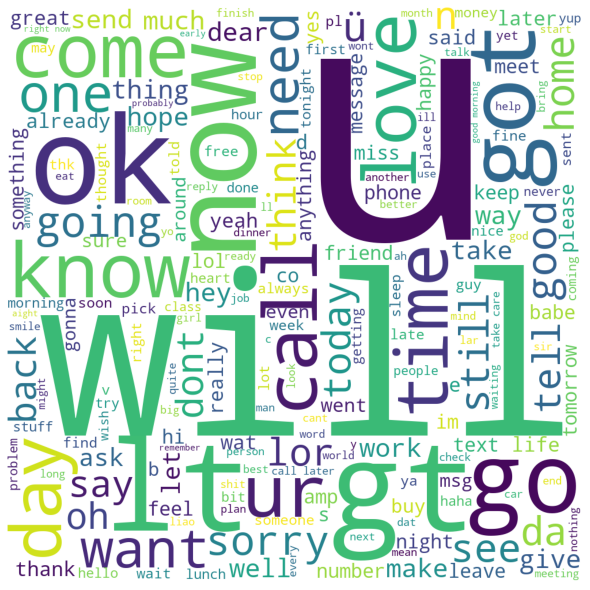

In [7]:
# Veamos las palabras que forman el label HAM (no spam)
cloud_stopwords = set(STOPWORDS)
ham_words = collect_words(df, label="ham")

print("Total words {}".format(len(ham_words)))

wordcloud = WordCloud(
    width=1000,
    height=1000,
    background_color="white",
    stopwords=cloud_stopwords,
    min_font_size=10,
).generate(ham_words)

# Plot del wordcloud
plt.figure(figsize=(15, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

--------------------------

## Wordcloud SPAM

Total words 104304


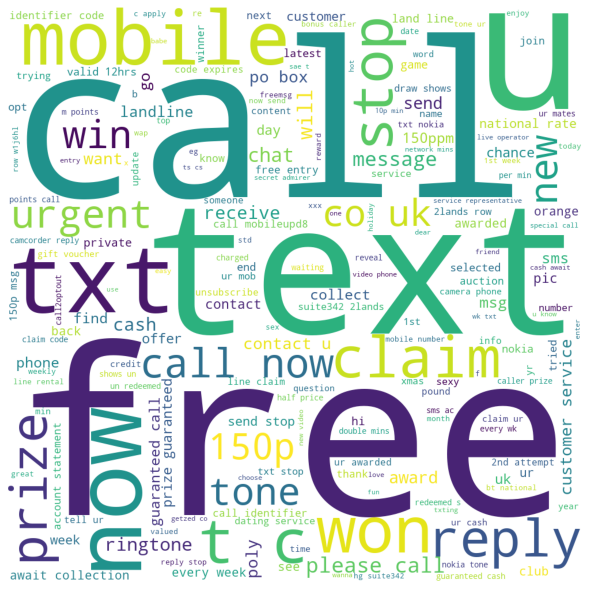

In [8]:
#  palabras que forman el label SPAM
cloud_stopwords = set(STOPWORDS)
spam_words = collect_words(df, label="spam")

print("Total words {}".format(len(spam_words)))

wordcloud = WordCloud(
    width=1000,
    height=1000,
    background_color="white",
    stopwords=cloud_stopwords,
    min_font_size=10,
).generate(spam_words)

# plot del Wordcloud
plt.figure(figsize=(10, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

---------------------

In [9]:
data = df.replace({"ham": 0, "spam": 1})
data.head()

,label,message,length,punct
0,0,"Go until jurong point, crazy.. Available only ...",111,9
1,0,Ok lar... Joking wif u oni...,29,6
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,6
3,0,U dun say so early hor... U c already then say...,49,6
4,0,"Nah I don't think he goes to usf, he lives aro...",61,2


# Limpieza de los textos

In [10]:
stop_words =  stopwords.words('english')

def text_cleaning(text, remove_stop_words=True, lemmatize_words=True):
    #Limpia el texto removiendo stop words y lemantizando
    
    # Transformacion de valores
    text = re.sub(r"[^A-Za-z0-9]", " ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"I'm", "I am", text)
    text = re.sub(r"ur", " your ", text)
    text = re.sub(r" nd "," and ",text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r" tkts "," tickets ",text)
    text = re.sub(r" c "," can ",text)
    text = re.sub(r" e g ", " eg ", text)
    text =  re.sub(r'http\S+',' link ', text)
    text = re.sub(r'\b\d+(?:\.\d+)?\s+', '', text) # remove numbers
    text = re.sub(r" u "," you ",text)
    text = text.lower()  # set in lowercase 
        
    # Remueve puntacion
    text = ''.join([c for c in text if c not in punctuation])
    
    # Quita las stopwords
    if remove_stop_words:
        text = text.split()
        text = [w for w in text if not w in stop_words]
        text = " ".join(text)
    
    # Lemantiza las palabras
    if lemmatize_words:
        text = text.split()
        lemmatizer = WordNetLemmatizer() 
        lemmatized_words = [lemmatizer.lemmatize(word) for word in text]
        text = " ".join(lemmatized_words)
    
    # Regresa la lista de palabras
    return(text)

#### text_cleaning() limpiara completamente el dataset

In [11]:
data["clean_message"] = data["message"].apply(text_cleaning)

In [12]:
data.head()

,label,message,length,punct,clean_message
0,0,"Go until jurong point, crazy.. Available only ...",111,9,go j ong point crazy available bugis n great w...
1,0,Ok lar... Joking wif u oni...,29,6,ok lar joking wif oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,6,free entry wkly comp win fa cup final ticket 2...
3,0,U dun say so early hor... U c already then say...,49,6,u dun say early hor u already say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,2,nah think go usf life around though


-----------------------

## Comenzamos a separar la data en Train y Test

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    data["clean_message"],
    data["label"],
    test_size=0.15,
    random_state=0,
    shuffle=True,
    stratify=df["label"],
)

In [14]:
# Count Vectorizer para pasar de texto a numerico
vectorizer = CountVectorizer(lowercase=False)
vectorizer.fit(X_train)

#Transformamos la data del Train
X_train_trans = vectorizer.transform(X_train)

#Transformamos la data del Test
X_text_trans = vectorizer.transform(X_test)

---------------

# Creamos el modelo clasificador
#### Utilizo Multinomial Naive Bayes porque es el mas popular y eficiente para clasificacion de textos

In [15]:
MNB = MultinomialNB()

## Entrenamos el modelo
#### Utilizo Cross Validation para evitar el overfitting

In [16]:
scores = cross_val_score(MNB,X_train_trans,y_train,cv=10,verbose=3,n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    2.1s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    2.1s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.2s finished


In [17]:
#Valor promedio de nuestro Score
scores.mean()

0.9767713936539371

In [18]:
# Optimizamos los parametros del modelo

distribution = {"alpha": [1, 0.1, 0.01, 0.001, 0.0001, 0, 0.2, 0.3]}

grid = RandomizedSearchCV(
    MNB,
    param_distributions=distribution,
    n_jobs=-1,
    cv=10,
    n_iter=20,
    random_state=42,
    return_train_score=True,
    verbose=2,
)

In [19]:
#Entrenamos con randomized
grid.fit(X_train_trans, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.0s finished


RandomizedSearchCV(cv=10, estimator=MultinomialNB(), n_iter=20, n_jobs=-1,
                   param_distributions={'alpha': [1, 0.1, 0.01, 0.001, 0.0001,
                                                  0, 0.2, 0.3]},
                   random_state=42, return_train_score=True, verbose=2)

In [20]:
# Resumimos los resuldatos de la busqueda 
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

0.9767713936539371
MultinomialNB(alpha=1)
{'alpha': 1}


## Testeamos

In [21]:
y_pred = grid.predict(X_text_trans)

In [22]:
#Resultado de nuestro modelo

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('Accuracy =', acc)
print('F1 =', f1)

Accuracy = 0.9760765550239234
F1 = 0.908256880733945


Guardamos nuestro clasificador y nuestro vectorizador

In [23]:
pickle.dump(grid, open('spam_classifier.sav', 'wb'))
pickle.dump(vectorizer, open('vectorizer.sav', 'wb'))